In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
#from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/Users/rafael/miniforge3/envs/classy-env/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/Users/rafael/miniforge3/envs/classy-env/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/Users/rafael/miniforge3/envs/classy-env/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/rafael/miniforge3/envs/classy-env/lib/python3.10/site-packages/traitlets/config/

-----------------------------
### 1. Loading and preprocessing data
-----------------------------

In [6]:
df = pd.read_csv("omega_cdm_theta_s0.05_0.2_N10000.csv")

X = df.iloc[:, 0].values.reshape(-1, 1)  # -> np.ndarray -> (infer # filas, 1 column)
y = df.iloc[:, 1].values.reshape(-1, 1)

In [22]:
# compute mean in "files" direction (for each feature and target)
X_norm = (X - X.mean(axis=0)) / X.std(axis=0)
y_norm = (y - y.mean(axis=0)) / y.std(axis=0)

# we store these for later use in predictions (normalization of input) and denormalization of output
y_mean = float(y.mean(axis=0))
y_std = float(y.std(axis=0))    
X_mean = float(X.mean(axis=0))  
X_std = float(X.std(axis=0))    


# Convert to tensors
X_tensor = torch.tensor(X_norm, dtype=torch.float32)
y_tensor = torch.tensor(y_norm, dtype=torch.float32)


class RegressionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = RegressionDataset(X_tensor, y_tensor)


# Split dataset
N = len(dataset)
train_size = int(0.80 * N)
val_size = int(0.15 * N)
test_size = N - train_size - val_size

train_set, val_set, Test_set = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader  = DataLoader(Test_set, batch_size=32, shuffle=False)


/var/folders/1b/_xbchkbd3vdgjnyj5vwm5x6m0000gn/T/ipykernel_11615/88544525.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_mean = float(y.mean(axis=0))
/var/folders/1b/_xbchkbd3vdgjnyj5vwm5x6m0000gn/T/ipykernel_11615/88544525.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_std = float(y.std(axis=0))
/var/folders/1b/_xbchkbd3vdgjnyj5vwm5x6m0000gn/T/ipykernel_11615/88544525.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  X_mean = float(X.mean(axis=0))


### data split plot

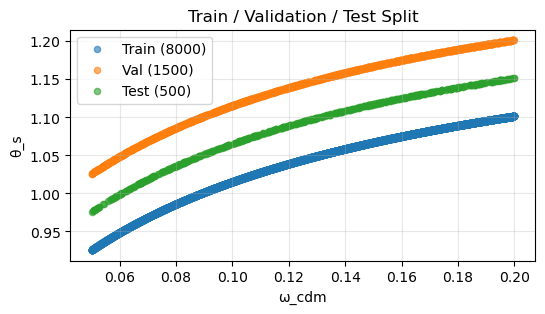

In [8]:
# Extract indices and data from each split
train_indices = train_set.indices
val_indices = val_set.indices
test_indices = test_set.indices

X_train = X[train_indices]
y_train = y[train_indices]

X_val = X[val_indices]
y_val = y[val_indices]

X_test = X[test_indices]
y_test = y[test_indices]

# Plot the three sets
plt.figure(figsize=(6, 3))
plt.scatter(X_train, y_train, s=20, alpha=0.6, label=f"Train ({len(train_indices)})")
plt.scatter(X_val,0.1+ y_val, s=20, alpha=0.6, label=f"Val ({len(val_indices)})")
plt.scatter(X_test, 0.05+ y_test, s=20, alpha=0.6, label=f"Test ({len(test_indices)})")

plt.xlabel("ω_cdm")
plt.ylabel("θ_s")
plt.title("Train / Validation / Test Split")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

-----------------------------
### 2. NN 
-----------------------------

In [9]:

class simpleNN(nn.Module):  # we inherit atributes and methods from nn.Module
    def __init__(self, in_dim=1, out_dim=1, n_neu1=5, n_neu2=5):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_dim, n_neu1),
            nn.ReLU(),
            nn.Linear(n_neu1, n_neu2),
            nn.ReLU(),
            nn.Linear(n_neu2, out_dim)
        )
    def forward(self, x):
        return self.layers(x)
    

In [10]:

class HuangNN(nn.Module):  # we inherit atributes and methods from nn.Module
    def __init__(self, N=1000, in_dim=1, out_dim=1):
        super().__init__()
        # Huang's formula for number of neurons
        n_neu1 = int( ((out_dim+2)*N)**0.5 + 2*(N/(out_dim+2))**0.5) 
        n_neu2 = int( out_dim*(N/(out_dim+2))**0.5) 
        self.layers = nn.Sequential(
            nn.Linear(in_dim, n_neu1),
            nn.ReLU(),
            nn.Linear(n_neu1, n_neu2),
            nn.ReLU(),
            nn.Linear(n_neu2, out_dim)
        )
    def forward(self, x):
        return self.layers(x)

-----------------------------
### 3. NN training
-----------------------------

In [11]:
def train_one_model(model, train_loader, val_loader, epochs=300, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # ----- Training -----
        model.train()
        total_train_loss = 0
        count_train_batches = 0
        for xb, yb in train_loader:
            pred = model(xb)
            loss = criterion(pred, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() # ignore other intrinsic values in loss
            count_train_batches += 1

        total_train_loss /= count_train_batches 
        # ----- Validation -----
        model.eval()
        total_val_loss = 0
        count_val_batches = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                pred = model(xb)
                total_val_loss += criterion(pred, yb).item()
                count_val_batches += 1

        total_val_loss /= count_val_batches

        train_losses.append(total_train_loss)
        val_losses.append(total_val_loss)

    return model, train_losses, val_losses


--------

In [ ]:
model1 = simpleNN(in_dim=1, out_dim=1, n_neu1=64)
model1, train_loss1, val_loss1 = train_one_model(model1, train_loader, val_loader, epochs=400, lr=1e-3)

In [93]:
model2 = simpleNN(in_dim=1, out_dim=1, n_neu1=100, n_neu2=4)
model2, train_loss2, val_loss2 = train_one_model(model2, train_loader, val_loader, epochs=400, lr=1e-3)

In [84]:
huang1 = HuangNN(in_dim=1, out_dim=1, N=1000)
huang1, huang_train_loss1, huang_val_loss1 = train_one_model(huang1, train_loader, val_loader, epochs=400, lr=1e-3)

In [134]:
new_huang1 = HuangNN(in_dim=1, out_dim=1, N=10000)
new_huang1, new_huang_train_loss1, new_huang_val_loss1 = train_one_model(new_huang1, train_loader, val_loader, epochs=400, lr=1e-3)

In [141]:
out_dim = 1
N=10000
n_neu1 = int( ((out_dim+2)*N)**0.5 + 2*(N/(out_dim+2))**0.5) 
n_neu2 = int( out_dim*(N/(out_dim+2))**0.5) 
n_neu1, n_neu2

(288, 57)

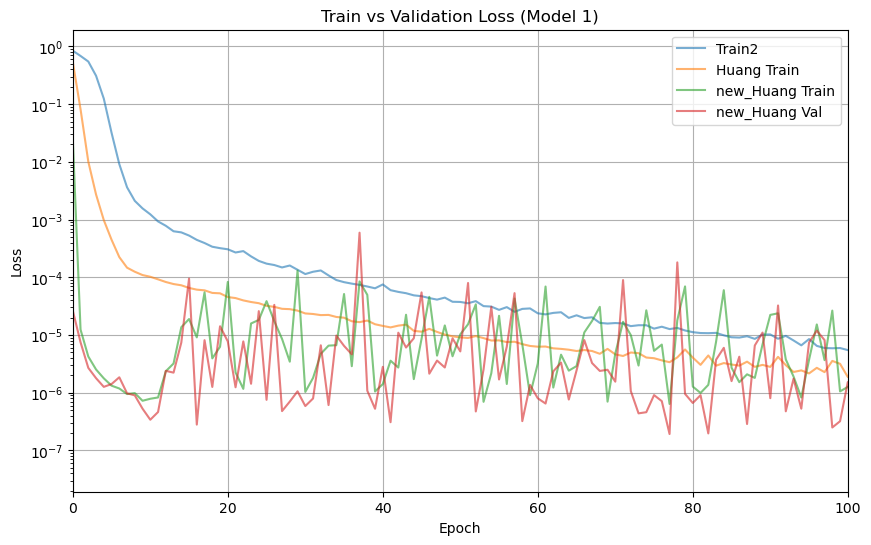

In [136]:
plt.figure(figsize=(10, 6))
epochs = range(1, len(train_loss1) + 1)
#plt.plot(train_loss1, label=f"Train", alpha=0.6)
#plt.plot(val_loss1, label=f"Val", alpha=0.6)

plt.plot(train_loss2, label=f"Train2", alpha=0.6)
#plt.plot(val_loss2, label=f"Val2", alpha=0.6)

plt.plot(huang_train_loss1, label=f"Huang Train", alpha=0.6)
#plt.plot(huang_val_loss1, label=f"Huang Val", alpha=0.6)

plt.plot(new_huang_train_loss1, label=f"new_Huang Train", alpha=0.6)
plt.plot(new_huang_val_loss1, label=f"new_Huang Val", alpha=0.6)

plt.xlabel("Epoch")
plt.xlim(0, len(train_loss1))
plt.ylabel("Loss")
plt.yscale('log')
plt.title("Train vs Validation Loss (Model 1)")

# xlimits, ylimits
plt.xlim(0, 100)
plt.legend()
plt.grid(True)
plt.show()


zoom

In [ ]:
plt.figure(figsize=(10, 6))
epochs = range(1, len(train_loss1) + 1)
plt.plot(train_loss1, label=f"Train", alpha=0.6)
plt.plot(val_loss1, label=f"Val", alpha=0.6)

plt.xlabel("Epoch")
# plt.xlim(0, len(train_loss1))
plt.xlim(400, len(train_loss1))
plt.ylim(0.0001, 0.001)
plt.ylabel("Loss")
plt.yscale('log')
plt.title("Train vs Validation Loss (Model 1)")
plt.legend()
plt.grid(True)
plt.show()


-----------------------------
### 4. Ensemble training
-----------------------------

In [15]:

def train_NNensemble(M=5, n_neu1=5, n_neu2=5, epochs=300, lr=1e-3, Huang=False):
    ensemble = []
    histories = []

    for i in range(M):
        print(f"\nTraining model {i+1}/{M}")
        if Huang:
            model = HuangNN(N=len(train_set), in_dim=1, out_dim=1)
        else:
            model = simpleNN(n_neu1=n_neu1, n_neu2=n_neu2)
        trained_model, train_hist, val_hist = train_one_model(model, train_loader, val_loader, epochs=epochs, lr=lr)
        ensemble.append(trained_model)
        histories.append((train_hist, val_hist))

    return ensemble, histories


------

In [106]:
ensemble10, histories10 = train_NNensemble(M=10,epochs=900)


Training model 1/10

Training model 2/10

Training model 3/10

Training model 4/10

Training model 5/10

Training model 6/10

Training model 7/10

Training model 8/10

Training model 9/10

Training model 10/10


In [104]:
fine_tuned_ensemble10, fine_tuned_histories10 = train_NNensemble(M=10, n_neu1=100, n_neu2=4, epochs=900)


Training model 1/10

Training model 2/10

Training model 3/10

Training model 4/10

Training model 5/10

Training model 6/10

Training model 7/10

Training model 8/10

Training model 9/10

Training model 10/10


In [ ]:
huang_ensemble10, huang_histories10 = train_NNensemble(M=10, epochs=900, Huang=True)


Training model 1/10

Training model 2/10

Training model 3/10

Training model 4/10

Training model 5/10

Training model 6/10

Training model 7/10

Training model 8/10

Training model 9/10

Training model 10/10


In [ ]:
fine_tuned2_ensemble10, fine_tuned2_histories10 = train_NNensemble(M=10, n_neu1=91, n_neu2=4, epochs=900)

In [16]:
new_huang_ensemble10, new_huang_histories10 = train_NNensemble(M=10, epochs=8, Huang=True)


Training model 1/10

Training model 2/10

Training model 3/10

Training model 4/10

Training model 5/10

Training model 6/10

Training model 7/10

Training model 8/10

Training model 9/10

Training model 10/10


-----------------------------
### 5.train vs validation Loss plot
-----------------------------

/var/folders/1b/_xbchkbd3vdgjnyj5vwm5x6m0000gn/T/ipykernel_1439/3112685133.py:22: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


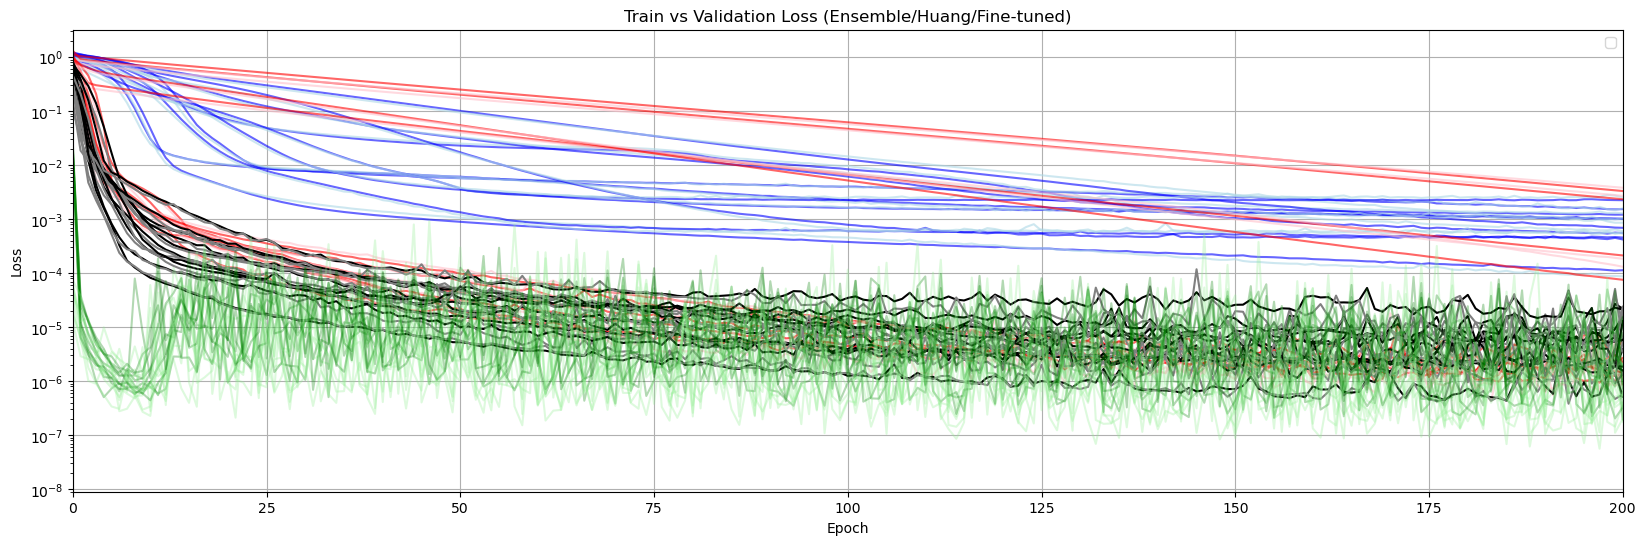

In [160]:
plt.figure(figsize=(20, 6))
for i, (train_hist, val_hist) in enumerate(histories10):
    plt.plot(train_hist, alpha=0.6, color='blue')
    plt.plot(val_hist, alpha=0.6, color='lightblue')
for i, (train_hist, val_hist) in enumerate(fine_tuned_histories10):
    plt.plot(train_hist, alpha=0.6, color='red')
    plt.plot(val_hist, alpha=0.6, color='pink')
for i, (train_hist, val_hist) in enumerate(huang_histories10):
    plt.plot(train_hist, alpha=1, color='black')
    plt.plot(val_hist, alpha=1, color='gray')
for i, (train_hist, val_hist) in enumerate(new_huang_histories10):
    plt.plot(train_hist, alpha=0.3, color='green')
    plt.plot(val_hist, alpha=0.3, color='lightgreen')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale('log')

# xlim
plt.xlim(0, 200)
plt.title("Train vs Validation Loss (Ensemble/Huang/Fine-tuned)")
plt.legend()
plt.grid(True)
plt.show()


/var/folders/1b/_xbchkbd3vdgjnyj5vwm5x6m0000gn/T/ipykernel_1439/3799486368.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


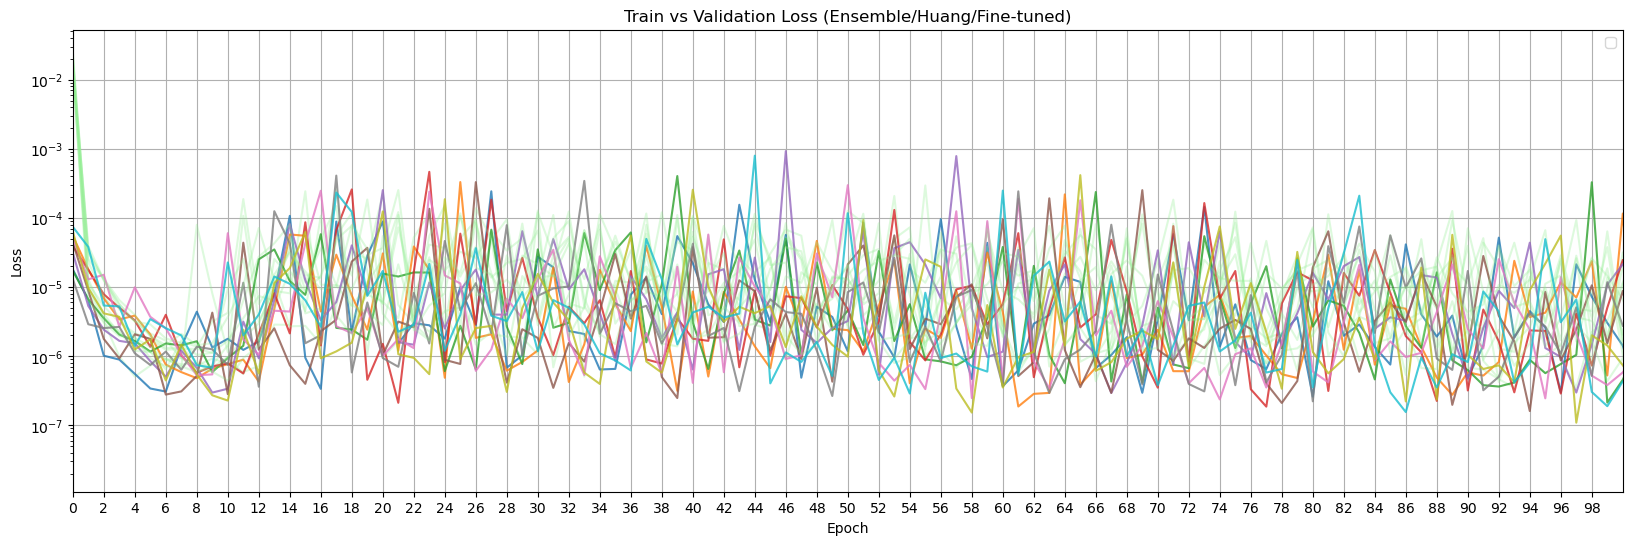

In [171]:
plt.figure(figsize=(20, 6))
for i, (train_hist, val_hist) in enumerate(new_huang_histories10):
    plt.plot(train_hist, alpha=0.3, color='lightgreen')
    plt.plot(val_hist, alpha=0.8)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale('log')

# xticks
plt.xticks(np.arange(0, 100, 2))
plt.xlim(0, 100)
plt.title("Train vs Validation Loss (Ensemble/Huang/Fine-tuned)")
plt.legend()
plt.grid(True)
plt.show()


/var/folders/1b/_xbchkbd3vdgjnyj5vwm5x6m0000gn/T/ipykernel_11615/3799486368.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


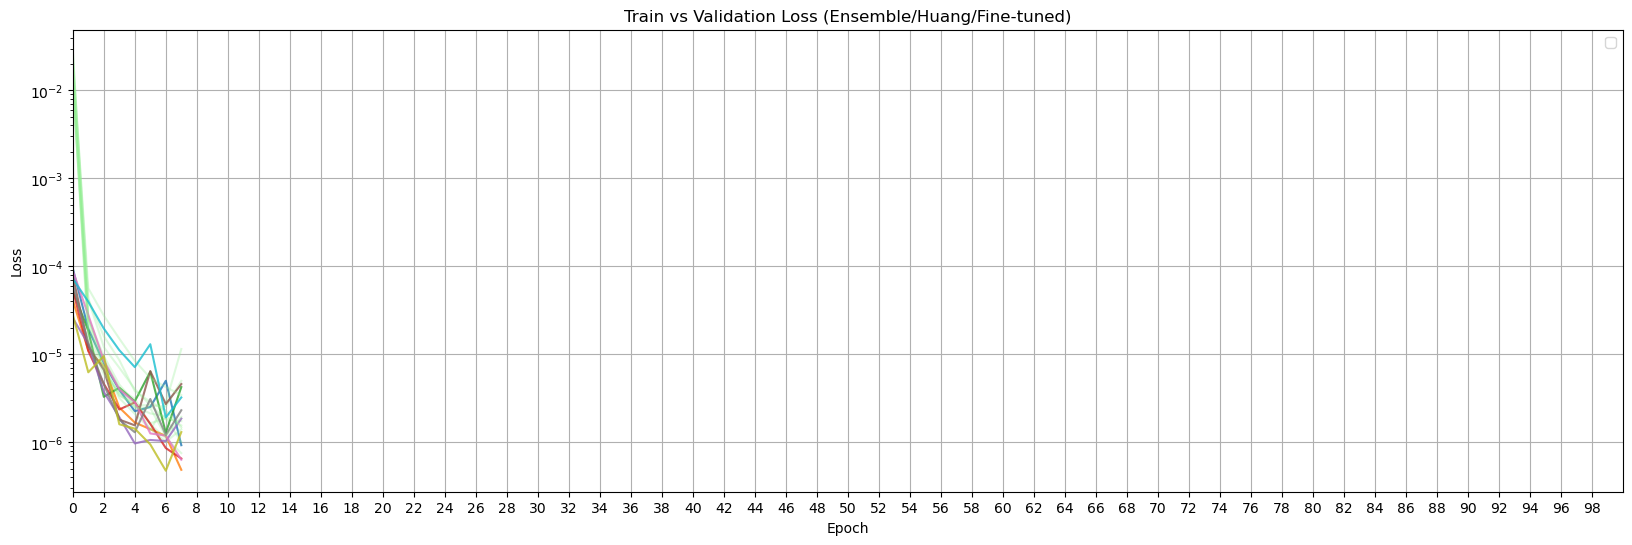

In [17]:
plt.figure(figsize=(20, 6))
for i, (train_hist, val_hist) in enumerate(new_huang_histories10):
    plt.plot(train_hist, alpha=0.3, color='lightgreen')
    plt.plot(val_hist, alpha=0.8)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale('log')

# xticks
plt.xticks(np.arange(0, 100, 2))
plt.xlim(0, 100)
plt.title("Train vs Validation Loss (Ensemble/Huang/Fine-tuned)")
plt.legend()
plt.grid(True)
plt.show()


-----------------------------
### 6. ENSEMBLE PREDICTION (MEAN, STD)
-----------------------------


In [46]:
def ensemble_predict(ensemble, x):
    global X_mean, X_std, y_mean, y_std
    x_normalized = (np.array(x).reshape(-1, 1) - X_mean) / X_std

    x_tensor = torch.tensor(x_normalized, dtype=torch.float32)

    preds = []
    for model in ensemble:
        model.eval()
        with torch.no_grad():
            pred = model(x_tensor)
            #print(type(pred))

            #preds.append(model(x_tensor).numpy().reshape(-1))
            #preds.append(pred.cpu().numpy().reshape(-1))  # Add .cpu() here
            #preds.append(pred.detach().cpu().numpy().reshape(-1))
            preds.append(pred.detach().cpu().tolist())


    preds = np.array(preds)  # shape (M, N)
    preds = preds*y_std+ y_mean # Denormalize 
    ensemble_mean = preds.mean(axis=0)
    ensemble_std  = preds.std(axis=0)

    return ensemble_mean, ensemble_std

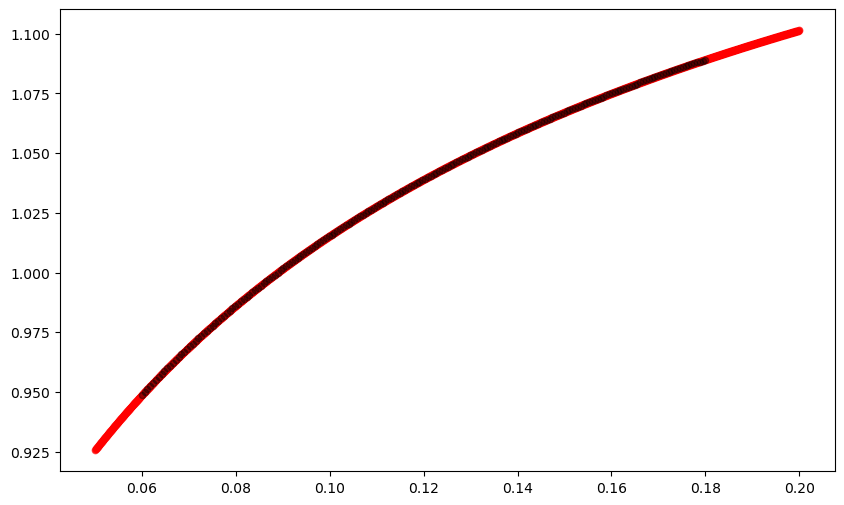

In [47]:
# Example prediction
xs = np.linspace(0.06, 0.18, 200)
mean, std = ensemble_predict(new_huang_ensemble10, xs) # USE ensemble1 if restart kernel


plt.figure(figsize=(10, 6))
plt.scatter(X, y, s=20, alpha=0.1, label="Data", color='red')
plt.scatter(xs, mean, s=20, alpha=0.4, label="Data", color='k')


-----------------------------
### 7.Final Testing
-----------------------------

In [48]:
# just convert test_set back to to numpy arrays
def extract_subset_to_numpy(subset):
    X_list = []
    y_list = []
    for x, y in subset:
        #denormalize
        x = x*X_std + X_mean
        y = y*y_std + y_mean
        X_list.append(x.detach().cpu().tolist())  
        y_list.append(y.detach().cpu().tolist())
    return np.array(X_list), np.array(y_list)

#use previous code again
testing_X, testing_y = extract_subset_to_numpy(Test_set)

In [ ]:
y_preds = []

with torch.no_grad():
    for x, _ in Test_loader:   # or test_loader
        y_hat = model(x)       # forward pass
        y_preds.append(y_hat.detach().cpu().tolist())

y_pred = np.array(y_preds)

MAE = np.mean(np.abs(testing_y - y_pred))
MSE = np.mean((testing_y - y_pred)**2)
RMSE = np.sqrt(MSE)
print(f"MAE: {MAE}, MSE: {MSE}, RMSE: {RMSE}")


MAE: 1.4173452804435272e-05, MSE: 4.1992651704513877e-10, RMSE: 2.0492108652970264e-05


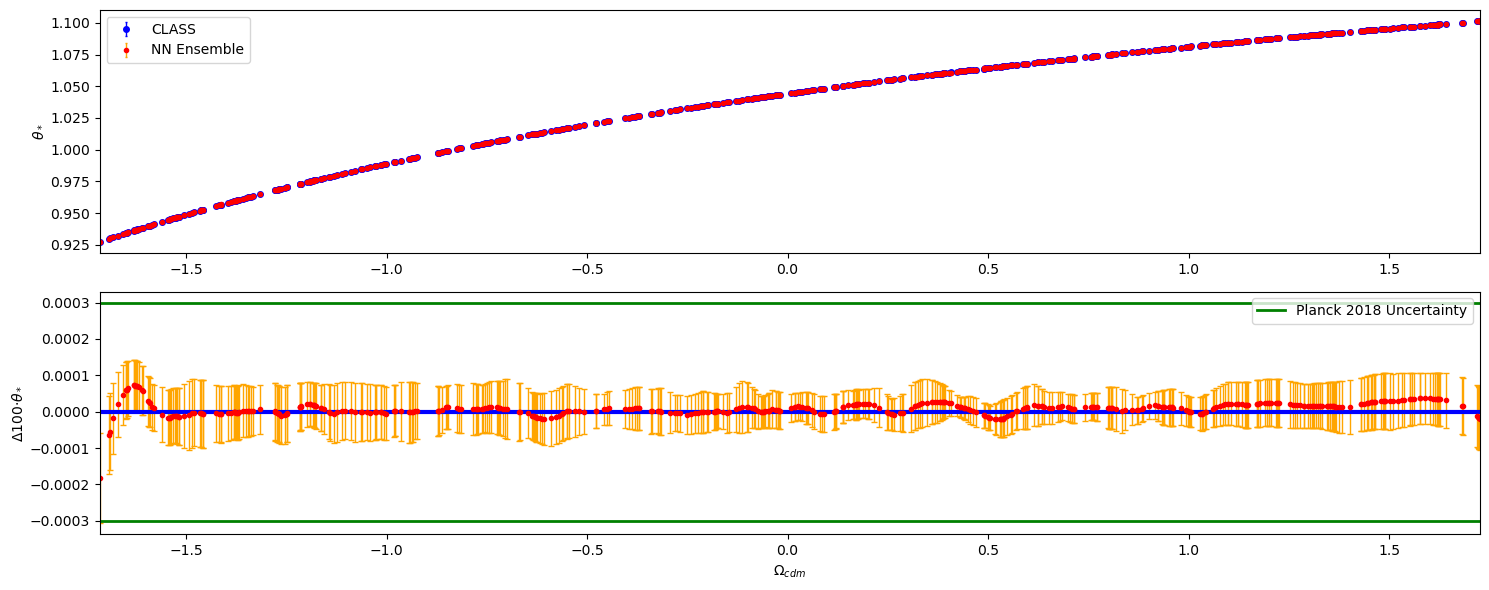

In [ ]:
#MAIN PLOT

y_pred = y_pred.ravel()
y_err = y_err.ravel()

test_X = test_X.ravel()

x_li = test_X.reshape(-1)
y_true_li = testing_y.reshape(-1)
y_pred_li = y_pred.reshape(-1)
y_err_li = y_err.reshape(-1)

fig = plt.figure(figsize=(15, 6))

# --- TOP PANEL --------------------------------------------------------
ax1 = plt.subplot2grid((2,1), (0,0))

ax1.errorbar(
    x_li, y_true_li, yerr=np.zeros_like(y_err_li),
    fmt='o', markersize=4, color='blue',
    ecolor='blue', elinewidth=1, capsize=1,
    label='CLASS'
)
ax1.errorbar(
    x_li, y_pred_li, yerr=y_err_li,
    fmt='o', markersize=3, color='red',
    ecolor='orange', elinewidth=1, capsize=1,
    label='NN Ensemble'
)


# ax1.plot(
#     x_li, y_true_li,
#     color='blue' , linewidth=1,
#     label='Model'
# )

ax1.set_ylabel(r"$\theta_*$")
ax1.set_xlim(min(x_li), max(x_li))
ax1.legend()
ax1.grid(False)

# --- BOTTOM PANEL (RESIDUALS) ----------------------------------------
ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)

residuals = y_true_li - y_pred_li

ax2.errorbar(
    x_li, residuals, yerr=y_err_li,
    fmt='o', markersize=3, color='red',
    ecolor='orange'
    
    
    , elinewidth=1, capsize=2
)

ax2.axhline(0, color='blue', linewidth=3)

y_err_PLANCK = 0.0003
ax2.axhline(y_err_PLANCK, color='green', linewidth=2, label='Planck 2018 Uncertainty')
ax2.axhline(-y_err_PLANCK, color='green', linewidth=2)

ax2.set_ylabel(r"$\Delta 100 · \theta_*$")
ax2.set_xlabel(r"$\Omega_{cdm}$")
ax2.set_xlim(min(x_li), max(x_li))

ax2.legend()


plt.tight_layout()
plt.show()

In [131]:
print(x_li.shape, y_true_li.shape)


(500,) (500,)


 -----------------------------
### 8. Real life usage exmple
-----------------------------

In [62]:
%time
y_pred, y_err = ensemble_predict(new_huang_ensemble10, np.array([0.12]))
print(f"Prediction for ω_cdm=0.12: θ_s = {y_pred[0]} ± {y_err[0]}")

CPU times: user 1 μs, sys: 1 μs, total: 2 μs
Wall time: 3.1 μs
Prediction for ω_cdm=0.12: θ_s = [1.03896455] ± [7.09997346e-05]
